<h2>Practical Tasks. Lesson 5<h2>

<h3>Import modules<h3>

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

import warnings
warnings.filterwarnings('ignore')

<h3>Task-1<h3>

In [2]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    # data_idxs = [i for i in range(n_samples)]
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        # OOB_idxs = list(set(data_idxs) - set(sample_index))
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [3]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    # min_samples_leaf = 5

    # max_features_number = 2 # ИЗМЕНЕНИЕ. Макс число признаков, по которым идет поиск оптимального критирия разбиения

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    # n_features = max_features_number if data.shape[1] > max_features_number else data.shape[1] # ИЗМЕНЕНИЕ
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            # if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                # continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    #     print(time.time(), true_branch) 
    false_branch = build_tree(false_data, false_labels)

#     print(time.time(), false_branch)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Influence of trees number on the algorithm accuracy

In [16]:
# сгенерируем данные, представляющие собой 1000 объектов с 2-мя признаками
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                n_features=2, n_informative=2, 
                                                                n_classes=2, n_redundant=0, 
                                                                n_clusters_per_class=2, random_state=23)

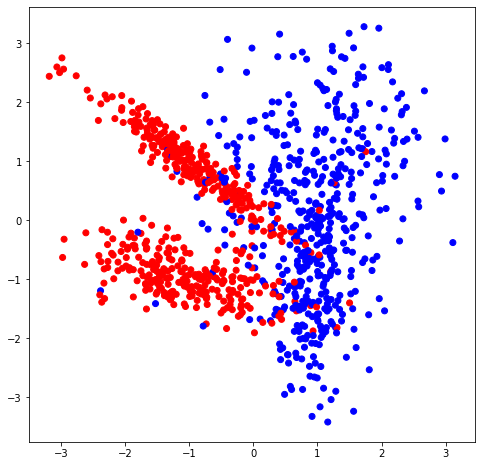

In [17]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
            c=classification_labels, cmap=colors)

In [18]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# ИЗМЕНЕНИЕ, обучаем несколько лесов с разным числом деревьев

N_trees = [1, 3, 10, 50] # число деревьев
forests = [] # 
train_accuracies, test_accuracies = [], []

for N in N_trees:
    current_forest  = random_forest(train_data, train_labels, N)
    forests.append(current_forest)
    train_answers = tree_vote(current_forest, train_data)
    test_answers = tree_vote(current_forest, test_data)
    train_accuracies.append(accuracy_metric(train_labels, train_answers))
    test_accuracies.append(accuracy_metric(test_labels, test_answers))

In [21]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forests):
    # create hyperplanes for test and train data at different number of trees in forest
    # forests - list of forests with different number of trees
    fig, axs = plt.subplots(figsize=(16, 7*len(forests)), nrows=len(forests), ncols=2, sharex=True, sharey=True)
    
    for i, row in enumerate(axs):
        ax_left, ax_right = row
        
        xx, yy = get_meshgrid(train_data)
        mesh_predictions = np.array(tree_vote(forests[i], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
        
        # график обучающей выборки
        ax_left.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
        ax_left.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
        ax_left.set_title(f'Train accuracy={train_accuracies[i]:.2f}')

        # график тестовой выборки
        ax_right.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
        ax_right.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
        ax_right.set_title(f'Test accuracy={test_accuracies[i]:.2f}')

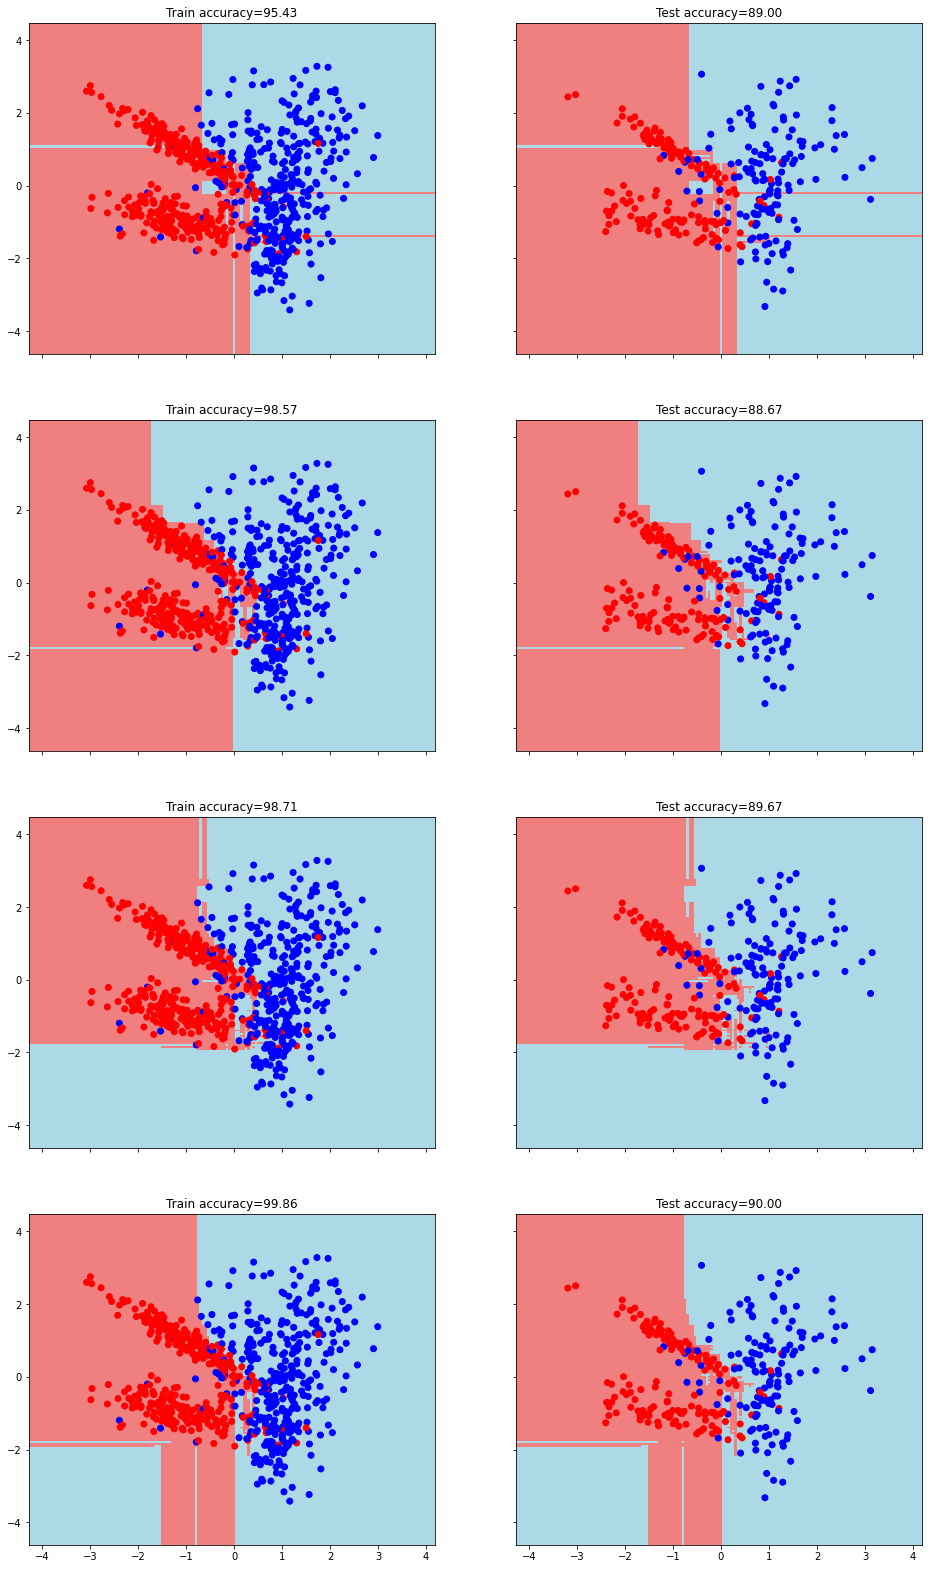

In [22]:
visualize(train_data, test_data, forests)

<h3>Task 2<h3>

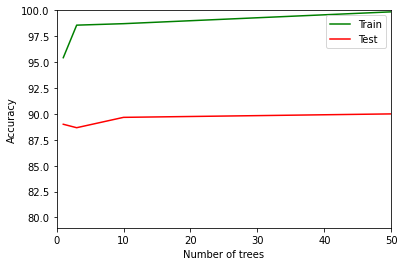

In [23]:
# visualize accuracy vs N_trees
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.ylim(int(min(min(train_accuracies), min(test_accuracies))*0.9), 100)
plt.xlim(0, max(N_trees))

plt.plot(N_trees, train_accuracies, color='g', label='Train')
plt.plot(N_trees, test_accuracies, color='r', label='Test')
plt.legend()


Вывод: последний график показывает, что точность предсказания на тестовой выборке с ростом числа деревьев в лесу постепенно выходит на плато (около 90%). При всех исследованных значениях N наблюдается переобучение, т.е. точность на тесте в среднем на 10 процентов ниже, чем на трейне. Об этом же свидетельствует сложное устройство гиперплоскости и стремление точности на трейне к 100 процентам с ростом числа деревьев. Изменение глубины дерева не оказало влияния на переобучение. Для борьбы с переобучением необходим учет дополнительных фичей, что должно позволить эффективно разделить классы за счет повышения размерности пространства признаков.